In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Let's take look at the first image
These images are generated from UnityEyes. Each image is a .jpg file and comes with a .json file of metadata. The json file contains locations of all the eye landmark positions withing the image. 

In [26]:
img1_path = './datasets/UnityEyes/imgs/1.jpg'
img1 = cv2.imread(img1_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

(600, 800, 3)

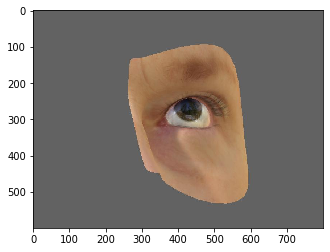

In [27]:
plt.imshow(img1)
img1.shape

## Image Json Data

In [28]:
import json

with open('./datasets/UnityEyes/imgs/1.json') as json_file:
    json_data = json.load(json_file)
print(json.dumps(json_data, indent=2))

{
  "interior_margin_2d": [
    "(371.4855, 296.4230, 8.8595)",
    "(364.8002, 307.1421, 8.8963)",
    "(377.6998, 328.0000, 8.8956)",
    "(405.9977, 352.2230, 8.9568)",
    "(441.1661, 357.7870, 9.1683)",
    "(467.5667, 342.2133, 9.4351)",
    "(483.2352, 324.5502, 9.6703)",
    "(489.5518, 306.1135, 9.8769)",
    "(489.8072, 291.6013, 10.0333)",
    "(488.4502, 285.3214, 9.8645)",
    "(480.7827, 278.0810, 9.5506)",
    "(465.4229, 275.8344, 9.2366)",
    "(445.8000, 275.4666, 9.0163)",
    "(420.2020, 277.2814, 8.8672)",
    "(392.7874, 280.7436, 8.8285)",
    "(377.1956, 285.5146, 8.8521)"
  ],
  "caruncle_2d": [
    "(364.5717, 284.7197, 8.8818)",
    "(364.8584, 288.3494, 8.8758)",
    "(357.4482, 296.9649, 8.8906)",
    "(349.9624, 289.0576, 8.8963)",
    "(353.7258, 283.3381, 8.8824)",
    "(351.5754, 280.2595, 8.8752)",
    "(346.2976, 282.7485, 8.8394)"
  ],
  "iris_2d": [
    "(389.0269, 332.5428, 8.8831)",
    "(388.8647, 339.9151, 8.9267)",
    "(390.1854, 346.9555, 8.9

32


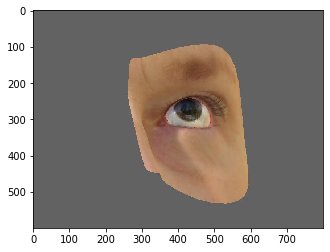

In [34]:
ih, iw = img1_gray.shape
iw_2, ih_2 = 0.5 * iw, 0.5 * ih

def process_coords(coords_list):
    coords = [eval(l) for l in coords_list]
    return np.array([(x, ih-y, z) for (x, y, z) in coords])
interior_landmarks = process_coords(json_data['interior_margin_2d'])
caruncle_landmarks = process_coords(json_data['caruncle_2d'])
iris_landmarks = process_coords(json_data['iris_2d'])

landmarks_img = img1.copy()
print(len(iris_landmarks))
for (x, y, z) in interior_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
for (x, y, z) in caruncle_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
for (x, y, z) in iris_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
plt.imshow(landmarks_img)
    

### Get the eye middle and corner locations and eye width

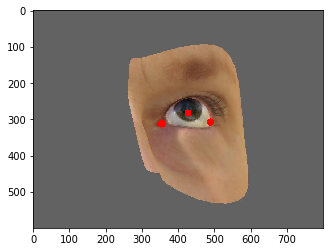

In [12]:
# Prepare to segment eye image
left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
right_corner = interior_landmarks[8, :2]
eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                      np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

lc = [int(x) for x in left_corner]
rc = [int(x) for x in right_corner]
em = [int(x) for x in eye_middle]
landmarks_img = img1.copy()
landmarks_img = cv2.circle(landmarks_img, tuple(lc), 10, color=(255, 0, 0), thickness=-1)
landmarks_img = cv2.circle(landmarks_img, tuple(rc), 10, color=(255, 0, 0), thickness=-1)
landmarks_img = cv2.circle(landmarks_img, tuple(em), 10, color=(255, 0, 0), thickness=-1)
plt.imshow(landmarks_img)

## Great! Now we'll cut out a sub-image centered on the eye middle. 
We want the the output image to be `90x150` pixels and have a width equal to the eye width. The affine transform will first scale the image so that the eye width equals 150 pixels. Then it centers on the eye middle and crops to `90x150` pixels.

(90, 150, 3)


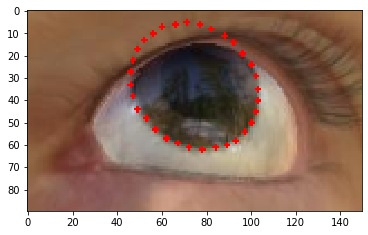

In [33]:
# Re-center so that eye-middle is at the center of the image
def preprocess_unityeyes_image(img, json_data, oh=90, ow=150):
    # Prepare to segment eye image
    
    def process_coords(coords_list):
        coords = [eval(l) for l in coords_list]
        return np.array([(x, ih-y, z) for (x, y, z) in coords])
    
    interior_landmarks = process_coords(json_data['interior_margin_2d'])
    caruncle_landmarks = process_coords(json_data['caruncle_2d'])
    iris_landmarks = process_coords(json_data['iris_2d'])

    left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
    right_corner = interior_landmarks[8, :2]
    eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
    eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                          np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

    scale = ow/eye_width
    original_eyeball_radius = 71.7593
    eyeball_radius = original_eyeball_radius * scale  # See: https://goo.gl/ZnXgDE
    radius = np.float32(eyeball_radius)

    transform = np.zeros((2, 3))
    transform[0, 2] = -eye_middle[0] * scale + 0.5 * ow # * scale_inv
    transform[1, 2] = -eye_middle[1] * scale + 0.5 * oh# * scale_inv
    transform[0, 0] = scale
    transform[1, 1] = scale
    
    transform_inv = np.zeros((2, 3))
    transform_inv[:, 2] = -transform[:, 2]
    transform_inv[0, 0] = 1/scale
    transform_inv[1, 1] = 1/scale
    
    # Apply transforms
    eye = cv2.warpAffine(img, transform, (ow, oh))    
    return {
        'img': eye,
        'transform': transform,
        'transform_inv': transform_inv,
        'radius': radius,
        'original_radius': original_eyeball_radius,
        'eye_middle': eye_middle
    }

eye_entry = preprocess_unityeyes_image(img1, json_data)

eye_img = eye_entry['img'].copy()
transform = eye_entry['transform']
for (x, y, z) in iris_landmarks:
    x, y = np.matmul(transform, [x, y, 1.0])
    eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
    
plt.imshow(eye_img)
print(eye_entry['img'].shape)

## Heatmaps
The next thing we need before we can start training is ground truth heatmaps for the model to compare its outputs against. We need one heatmap per iris landmark (32 heatmaps). Each heatmap will have the same dimensions as the input image, but only 1 channel. 

Heat maps are created.

In [41]:
def get_heatmaps(shape, json_data, transform):
    def process_coords(coords_list):
        coords = [eval(l) for l in coords_list]
        return np.array([(x, ih-y, z) for (x, y, z) in coords])
    iris_landmarks = process_coords(json_data['iris_2d'])    
    
    def gaussian_2d(shape, centre, sigma=1.0):
        """Generate heatmap with single 2D gaussian."""
        xs = np.arange(0.5, shape[1] + 0.5, step=1.0, dtype=np.float32)
        ys = np.expand_dims(np.arange(0.5, shape[0] + 0.5, step=1.0, dtype=np.float32), -1)
        alpha = -0.5 / (sigma**2)
        heatmap = np.exp(alpha * ((xs - centre[0])**2 + (ys - centre[1])**2))
        return heatmap

    heatmaps = []
    for (x, y, z) in iris_landmarks:
        x, y = np.matmul(transform, [x, y, 1.0])
        heatmaps.append(gaussian_2d(shape, (int(x), int(y)), sigma=5.0))
    return heatmaps
    

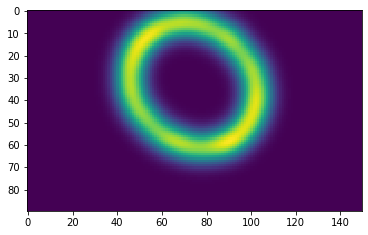

In [45]:
heatmaps = get_heatmaps((90,150), json_data, transform)
merged_heatmaps = np.mean(heatmaps, axis=0)
plt.imshow(merged_heatmaps * 255)